<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF-285 - Computación Científica </h1>
    <h2> Floating Point Arithmetic </h2>
    <h2> <a href="#acknowledgements"> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 1.22 </h2>
</center>


<div id='toc' />

## Table of Contents
* [Introduction](#intro)
* [The nature of floating point numbers](#nature)
* [Visualization of floating point numbers](#visualization)
* [What is the first integer that is not representable in double precision?](#firstinteger)
* [Loss of significance](#loss)
* [Loss of significance in funcion evaluation](#func)
* [Another analysis (example from textbook)](#another)
* [Acknowledgements](#acknowledgements)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<div id='intro' />

## Introduction
[Back to TOC](#toc)

Hello! This notebook is an introduction to how our computers handle the representation of real numbers using double-precision floating-point standard IEEE 754. 
To understand the contents of this notebook you should have at least a basic notion of how binary numbers work.

The double-precision floating-point format occupies 64 bits which are divided as follows:

* 1 bit for the sign
* 11 bits for the exponent
* 52 bits for the mantissa

This means that the very next representable number after $1$ is $1 + 2^{-52}$, and their difference, $2^{-52}$, is the called $\epsilon_{mach}$.

Additionally, if you'd like to quickly go from a base-2 integer to a base-10 integer and viceversa, Python has some functions that can help you with that.

In [2]:
# This code translate from a binary number using the prefix "0b" to a base 10 number.
int('0b11', 2)

3

In [3]:
# This code translate from base 10 to base 2.
bin(9)

'0b1001'

In [4]:
# Just looking a large binary number
bin(2**53)

'0b100000000000000000000000000000000000000000000000000000'

<div id='nature' />

## The nature of floating point numbers
[Back to TOC](#toc)

As we know until now, float representations of real numbers are just a finite and bounded representation of them. 
But another interesting thing is that these floating point numbers are distributed across the real numbers not uniformly.

To see that, it's really important to keep in mind the following property of floating point numbers:
$$
\begin{equation*} 
    \left|\frac{\text{fl}(x)-x}{x}\right| \leq \frac{1}{2} \epsilon_{\text{mach}}, 
\end{equation*}
$$
where $\text{fl}(x)$ means the floating point representation of $x \in \mathbb{R}$, this means that $\text{fl}(x)$ is the actual number that is stored in memory when we try to store the number $x$. 
What it says is that **the relative error in representing any non-zero real number x is bounded by a quantity that depends on the precision bing used**, i.e. ($\epsilon_{\text{mach}}$).

Maybe, now you're thinking: What does this relationship have to do with the distribution of floating point numbers? 
So, if we rewrite the previous as follows we get:
$$
\begin{equation} 
    |\text{fl}(x)-x| \leq \frac{1}{2} \epsilon_{\text{mach}}\,|x|.
\end{equation}
$$
It's clear then: **The absolute error (distance) between a real number and its floating point representation is proportional to the real number's magnitude.**

Intuitively speaking, the representation error of a number increases as its magnitude increases, this implies that **the distance between a floating point number and the next representable floating point number will increase as the magnitude of such number increases (and conversely)**. 
Could you prove that?  
For now, we will prove it numerically.

We will use a library named **bitstring** to visualize what it is being stored in double precision. 
You can install it with:
```
pip install bitstring
```

In [5]:
import bitstring as bs

The next two functions are self-explanatory:

1. `next_float(f)` computes the next representable float number right after $f$.
2. `gap(f)` computes the difference between $f$ and the next representable float number.

Notice that here we are considering that we are using double-precision.

In [6]:
def next_float(f):
    #packing double-precision foat
    b = bs.pack('>d', f)
    
    #extracting mantisa as unsigned int and adding up 1.
    # There are two cases, (1) if the bits of the mantissa are all 1,
    # (2) all the other cases.
    m = b[12:].uint
    if m==4503599627370495:
        # Case (1)
        m=0
        b[12:] = m
        exp=b[1:12].uint
        exp +=1
        b[1:12] = exp
        
    else:
        # Case (2)
        m += 1
        # putting the result in his place
        b[12:] = m
    
    return b.float

def gap(f):
    next_f = next_float(f)
    return next_f - f

So if we compute `gap(1)` we should get machine epsilon. 
Let's try it:

In [7]:
gap(1)

2.220446049250313e-16

In [8]:
# What happens when we increase the value?
gap(2**40)

0.000244140625

In [9]:
# When will the gap be greater that 1?
print(gap(2.**52))
print(gap(2.**53))
# What does it mean to have a gap larger than 1?

1.0
2.0


In order to prove our hypothesis (that floating point numbers are not uniformly distributed), we will create an array of values: $[2^{-5},...,2^{60}]$ and compute their corresponding gaps.

In [12]:
values = np.array([2**i for i in range(-5,60)]).astype(float)

# Corresponding gaps:
# The Numpy function "vectorize" is very useful to be use one wants to apply
# a scalar function to each element of an array.
vgap = np.vectorize(gap)
gaps = vgap(values)

We include now a comparison between a linear scale plot and a loglog scale plot. Which one is more useful here?

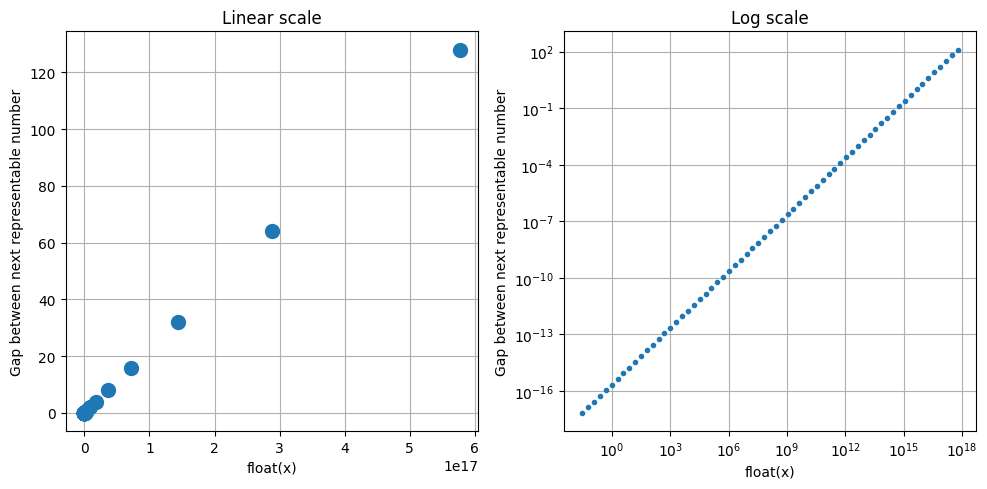

In [13]:
fig = plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(values, gaps,'.',markersize=20)
plt.xlabel('float(x)')
plt.ylabel('Gap between next representable number')
plt.title('Linear scale')
plt.grid(True)

plt.subplot(122)
plt.loglog(values, gaps,'.')
plt.xlabel('float(x)')
plt.ylabel('Gap between next representable number')
plt.title('Log scale')
plt.grid(True)

fig.tight_layout()
plt.show()

As you can see, the hypothesis was right. In other words: Floating point numbers are not uniformly distributed across the real numbers, and the distance between them is proportional to their magnitude. 
**Tiny numbers (~ 0) are closer between each other than larger numbers are.**

Moreover, we can conclude that for large values the gap is larger that $1$, **which means that there will be integers that will not be stored!!**.

<div id='visualization' />

## Visualization of floating point numbers
[Back to TOC](#toc)

With the help of `bitstring` library we could write a function to visualize floating point numbers in its binary representation.

In [14]:
# This function shows the bits used for the sign, exponent and mantissa for a 64-bit double presision number.
# fps: Floating Point Standard
# Double: Double precision IEEE 754
def to_fps_double(f):
    b = bs.pack('>d', f)
    b = b.bin
    #show sign + exponent + mantisa
    print(b[0]+' '+b[1:12]+ ' '+b[12:])

Let's see some intereseting examples

In [15]:
to_fps_double(1.)

0 01111111111 0000000000000000000000000000000000000000000000000000


In [23]:
int('0b01111111111', 2)

1023

In [24]:
to_fps_double(1.+gap(1.))

0 01111111111 0000000000000000000000000000000000000000000000000001


In [25]:
to_fps_double(+0.)

0 00000000000 0000000000000000000000000000000000000000000000000000


In [26]:
to_fps_double(-0.)

1 00000000000 0000000000000000000000000000000000000000000000000000


In [20]:
to_fps_double(np.inf)

0 11111111111 0000000000000000000000000000000000000000000000000000


In [21]:
to_fps_double(-np.inf)

1 11111111111 0000000000000000000000000000000000000000000000000000


In [27]:
to_fps_double(np.nan)

0 11111111111 1000000000000000000000000000000000000000000000000000


In [28]:
to_fps_double(-np.nan)

1 11111111111 1000000000000000000000000000000000000000000000000000


In [29]:
to_fps_double(2.**-1074)

0 00000000000 0000000000000000000000000000000000000000000000000001


In [30]:
print(2.**-1074)

5e-324


In [31]:
to_fps_double(2.**-1075)

0 00000000000 0000000000000000000000000000000000000000000000000001


In [32]:
print(2.**-1075)

5e-324


In [33]:
to_fps_double(9.4)

0 10000000010 0010110011001100110011001100110011001100110011001101


<div id='firstinteger' />

## What is the first integer that is not representable in double precision?
[Back to TOC](#toc)

Recall that $\epsilon_{\text{mach}}=2^{-52}$ in double precision.

In [33]:
to_fps_double(1)
to_fps_double(1+2**-52)

0 01111111111 0000000000000000000000000000000000000000000000000000
0 01111111111 0000000000000000000000000000000000000000000000000001


This means that if we want to store any number in the interval $[1,1+\epsilon_{\text{mach}}]$, only the numbers $1$ and $1+\epsilon_{\text{mach}}$ will be stored. For example, compare the exponent and the mantissa in the previous cell with the following outputs:

In [34]:
for i in np.arange(1,11):
    to_fps_double(1+i*2**-55)

0 01111111111 0000000000000000000000000000000000000000000000000000
0 01111111111 0000000000000000000000000000000000000000000000000000
0 01111111111 0000000000000000000000000000000000000000000000000000
0 01111111111 0000000000000000000000000000000000000000000000000000
0 01111111111 0000000000000000000000000000000000000000000000000001
0 01111111111 0000000000000000000000000000000000000000000000000001
0 01111111111 0000000000000000000000000000000000000000000000000001
0 01111111111 0000000000000000000000000000000000000000000000000001
0 01111111111 0000000000000000000000000000000000000000000000000001
0 01111111111 0000000000000000000000000000000000000000000000000001


Now, we can scale this difference such that the scaling factor multiplied but $\epsilon_{\text{mach}}$ is one. The factor will be $2^{52}$. This means $2^{52}\,\epsilon_{\text{mach}}=1$. Repeating the same example as before but with the scaling factor we obtain:

In [35]:
for i in np.arange(11):
    to_fps_double((1+i*2**-55)*2**52)

0 10000110011 0000000000000000000000000000000000000000000000000000
0 10000110011 0000000000000000000000000000000000000000000000000000
0 10000110011 0000000000000000000000000000000000000000000000000000
0 10000110011 0000000000000000000000000000000000000000000000000000
0 10000110011 0000000000000000000000000000000000000000000000000000
0 10000110011 0000000000000000000000000000000000000000000000000001
0 10000110011 0000000000000000000000000000000000000000000000000001
0 10000110011 0000000000000000000000000000000000000000000000000001
0 10000110011 0000000000000000000000000000000000000000000000000001
0 10000110011 0000000000000000000000000000000000000000000000000001
0 10000110011 0000000000000000000000000000000000000000000000000001


Which means we can only store exactly the numbers:

In [36]:
to_fps_double(2**52)
to_fps_double(2**52+1)

0 10000110011 0000000000000000000000000000000000000000000000000000
0 10000110011 0000000000000000000000000000000000000000000000000001


This means, the distance now from $2^{52}$ and the following number representable is $1$ !!!! So, what would happend if I can to store $2^{53}+1$?

In [37]:
to_fps_double(2**53)
to_fps_double(2**53+1)
to_fps_double(2**53+2)
to_fps_double(2**53+3)
to_fps_double(2**53+4)

0 10000110100 0000000000000000000000000000000000000000000000000000
0 10000110100 0000000000000000000000000000000000000000000000000000
0 10000110100 0000000000000000000000000000000000000000000000000001
0 10000110100 0000000000000000000000000000000000000000000000000010
0 10000110100 0000000000000000000000000000000000000000000000000010


I can't stored the **Integer** $2^{53}+1$! Thus, the first integer not representable is $2^{53}+1$.

<div id='error_bound' />

## Understanding the error bound between |fl(x)-x|
[Back to TOC](#toc)

The following code shows a plot of the upper bound of the absolute error we are making when storing the value $x$ as a floating point in double precision, i.e. fl $(x)$.
This means:
$$
    \begin{equation*} 
        |\text{fl}(x)-x| \leq \frac{1}{2} \epsilon_{\text{mach}} |x| 
    \end{equation*}.
$$

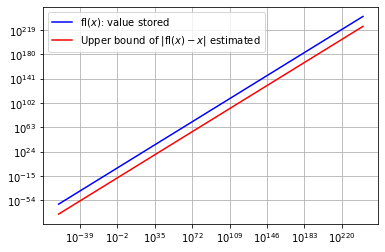

In [38]:
x = np.logspace(-200,800,1000, base=2, dtype=np.dtype(float))
plt.figure()
plt.loglog(x,x,'b',label='fl$(x)$: value stored')
plt.loglog(x,np.power(2.,-52)*np.abs(x)/2,'r',label='Upper bound of $|$fl$(x)-x|$ estimated')
plt.legend(loc='best')
plt.grid(True)
plt.show()

As you may have expected, the error grows proportionally with the value of $x$.
It is importnant however that you don't get confused with the apparently small difference between the blue and the red lines, actuallu that difference is about 16-order of magnitud!
Just look at the $y$-axis scale, it is a logarithmic scale.

The outcome of this example is that it tells us that the absolute error we are making when we store the value $x$ as a double precision floating point fl $(x)$ is proportional to $x$, this is what it is.
The key point is that we must always remember this.

<div id='loss' />

## Loss of significance
[Back to TOC](#toc)

As we mentioned, there's a small gap between 1 and the next representable number, which means that if you want to represent a number between those two, you won't be able to do so; what you would need to do is to round it to a representable number before storing it in memory.

In [39]:
a = 1.
b = 2.**(-52) #emach
result_1 = a + b     # arithmetic result is 1.0000000000000002220446049250313080847263336181640625
result_1b = result_1-1.0
print("{0:.1000}".format(result_1))
print(result_1b)
print(b)

1.0000000000000002220446049250313080847263336181640625
2.220446049250313e-16
2.220446049250313e-16


In [40]:
c = 2.**(-53)
result_2 = a + c     # arithmetic result is 1.00000000000000011102230246251565404236316680908203125
np.set_printoptions(precision=16)
print("{0:.1000}".format(result_2))
print(result_2-a)

1.0
0.0


In [41]:
to_fps_double(result_2)
to_fps_double(result_2-a)

0 01111111111 0000000000000000000000000000000000000000000000000000
0 00000000000 0000000000000000000000000000000000000000000000000000


In [42]:
d = 2.**(-53) + 2.**(-54)

result_3 = a + d     # arithmetic result is 1.000000000000000166533453693773481063544750213623046875
print("{0:.1000}".format(result_3))
to_fps_double(result_3)
to_fps_double(d)

1.0000000000000002220446049250313080847263336181640625
0 01111111111 0000000000000000000000000000000000000000000000000001
0 01111001010 1000000000000000000000000000000000000000000000000000


As you can see, if you try to save a number between $1$ and $1 + \epsilon _{mach}$, it will have to be rounded (according to IEEE rounding criteria) to a representable number before being stored, thus creating a difference between the _real_ number and the _stored_ number. 
This situation is an example of loss of significance.

Does that mean that the _gap_ between representable numbers is _always_ going to be $\epsilon _{mach}$? Of course not! Some numbers will have smaller gaps, and some others will require larger gaps, as studied before. 

In any interval of the form $[2^n,2^{n+1}]$ for representable $n\in \mathbb{Z}$, the gap is constant. 
For example, all the numbers between $2^{-1}$ and $2^0$ have a distance of $\epsilon _{mach}/2$ between them. 
All the numbers between $2^0$ and $2^1$ have a distance of $\epsilon _{mach}$ between them. 
Those between $2^1$ and $2^2$ have a distance of $2\,\epsilon _{mach}$ between them, and so on.

In [43]:
# What does it mean to store 0.5+delta?
e = 2.**(-1)
f = b/2. # emach/2

result_4 = e + f     # 0.50000000000000011102230246251565404236316680908203125
print("{0:.100}".format(result_4))

result_5 = e + b     # 0.5000000000000002220446049250313080847263336181640625
print("{0:.100}".format(result_5))

0.50000000000000011102230246251565404236316680908203125
0.5000000000000002220446049250313080847263336181640625


In [44]:
g = b/4.

result_5 = e + g     # 0.500000000000000055511151231257827021181583404541015625
print("{0:.100}".format(result_5))

0.5


We'll let the students find some representable numbers and some non-representable numbers.

In [45]:
num_1 = a
num_2 = b
result = a + b
print("{0:.100}".format(result))

1.0000000000000002220446049250313080847263336181640625


<div id='func' />

## Loss of significance in function evaluation
[Back to TOC](#toc)

Loss of Significance is present too in the representation of **functions**. A classical example (which you can see in the guide book), is the next function: 

$$
\begin{equation}
    f_1(x)= \frac{1 - \cos x}{\sin^{2}x} 
\end{equation}
$$

Applying trigonometric identities, we can obtain the 'equivalent' function:
$$
\begin{equation}
    f_2(x)= \frac{1}{1 + \cos x} 
\end{equation}
$$

Both of these functions are apparently equals in exact arithmetic. Nevertheless, its graphics say to us another thing when $x$ is equal to zero.

Before we analize the behaviour about $x=0$, let's take a look at them in the range $x\in[-10,10]$.

In [46]:
f1 = lambda x: (1.-np.cos(x))/(np.power(np.sin(x),2))
f2 = lambda x: 1./(1+np.cos(x))

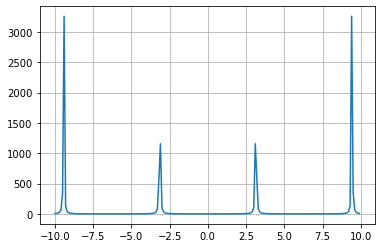

In [47]:
x = np.arange(-10,10,0.1)
plt.figure()
plt.plot(x,f1(x),'-')
plt.grid(True)
plt.show()

The first plot shows some spikes, are these expected? or is it an artifact?
Notice that we mean that something it is an artifact when it only appears due to a numerical computation but it should not be there theoretically.
Are these spikes real or not?

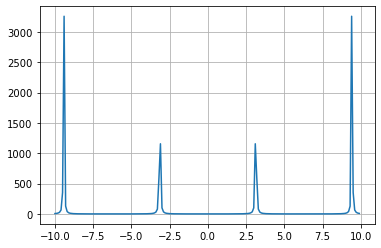

In [48]:
plt.figure()
plt.plot(x,f2(x),'-')
plt.grid(True)
plt.show()

The second function also shows the spikes! It seems they are real.
Actually, they are real!
At which points do we expect them?
Do we expect them at $x=0$?

To answer the last question, we will plot the functions in the range $x\in[-1,1]$.

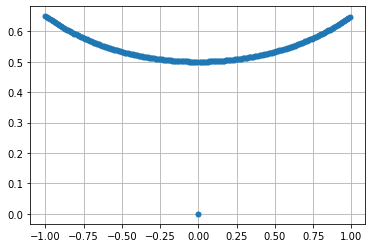

In [49]:
x = np.arange(-1,1,0.01)
plt.figure()
plt.plot(x,f1(x),'.',markersize=10)
plt.grid(True)
plt.show()

In the previous function, we see an _outlier_ at $x=0$, this point is telling us that $f_1(x)$ at $x=0$ seems to be $0$.
Is this real or it is an artifact?

Let's look at the plot of $f_2(x)$ in the same range.

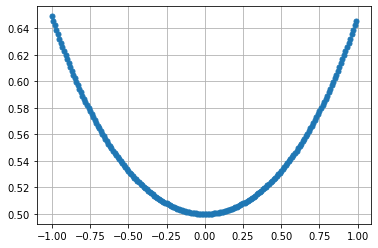

In [50]:
plt.figure()
plt.plot(x,f2(x),'.',markersize=10)
plt.grid(True)
plt.show()

In this case we see a different behavior. Is this the correct one?
Yes!

This happens because when $x$ is equal to zero, the first function has an indetermination, but previously, the computer makes a subtraction between numbers that are almost equals. This generates a loss of significance, turning the expression close to this point to be zero. 
However, modifying this expression to make the second function, eliminates this substraction, fixing the error in its calculation when $x=0$.

In conclusion, for us, two representations of a function can be equals in exact arithmetic, but for the computer they can be different!

<div id='another' />

## Another analysis (example from textbook)
[Back to TOC](#toc)

The following code tries to explain why $f_1(x)$ gives $0$ near $x=0$.

In [51]:
# This function corresponds to the numerator of f1(x)
f3 = lambda x: (1.-np.cos(x))
# This function corresponds to the denominator of f2(x)
f4 = lambda x: np.power(np.sin(x),2)
x = np.flip(np.logspace(-19,0,20))
o1 = f1(x)
o2 = f2(x)
o3 = f3(x)
o4 = f4(x)

print("x,            f1(x),        f2(x),        f3(x),                       f4(x)")
for i in np.arange(len(x)):
    print("%1.10f, %1.10f, %1.10f, %1.25f, %1.25f" % (x[i],o1[i],o2[i],o3[i],o4[i]))

x,            f1(x),        f2(x),        f3(x),                       f4(x)
1.0000000000, 0.6492232052, 0.6492232052, 0.4596976941318602349895173, 0.7080734182735711756961905
0.1000000000, 0.5012520863, 0.5012520863, 0.0049958347219742904599116, 0.0099667110793791851425238
0.0100000000, 0.5000125002, 0.5000125002, 0.0000499995833347366414046, 0.0000999966667111107946004
0.0010000000, 0.5000001250, 0.5000001250, 0.0000004999999583255032576, 0.0000009999996666667110814
0.0001000000, 0.4999999986, 0.5000000012, 0.0000000049999999696126451, 0.0000000099999999666666680
0.0000100000, 0.5000000414, 0.5000000000, 0.0000000000500000041370185, 0.0000000000999999999966667
0.0000010000, 0.5000444503, 0.5000000000, 0.0000000000005000444502912, 0.0000000000009999999999997
0.0000001000, 0.4996003611, 0.5000000000, 0.0000000000000049960036108, 0.0000000000000100000000000
0.0000000100, 0.0000000000, 0.5000000000, 0.0000000000000000000000000, 0.0000000000000001000000000
0.0000000010, 0.0000000000, 0.50

From teh previous table, we see that the numerator of $f_1(x)$ becomes $0$. What is happening with $1-\cos(x)$ about $x=0$?

In the following code we study numerically what happens with $1-\cos(x)$ as $x$ tends to $0^+$.

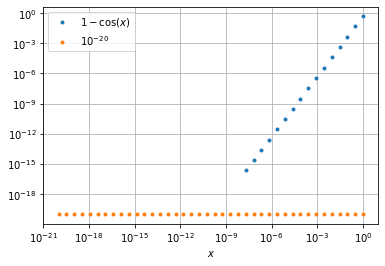

In [52]:
x = np.logspace(-20,0,40)
plt.figure()
plt.loglog(x,1-np.cos(x),'.',label='$1-\cos(x)$')
plt.loglog(x,0*x+1e-20,'.', label='$10^{-20}$')
plt.grid(True)
plt.xlabel('$x$')
plt.legend(loc='best')
plt.show()

In [53]:
# For this value of x=1e-7 we obtain an outcome greater than 0
to_fps_double(1-np.cos(1.e-7))
# But for x=1e-8 we actually get 0. This explains why in the previous plot the blue dots stop appearing for values less or equal than 1e-8 approximately.
to_fps_double(1-np.cos(1.e-8))

0 01111001111 0110100000000000000000000000000000000000000000000000
0 00000000000 0000000000000000000000000000000000000000000000000000


## Another example: quadratic formula

Find the _positive_ root from the quadratic formula of:
$$
x^2+10^{10}\,x-1=0.
$$
The positive root is:
$$
x_+ = \dfrac{-10^{10}+\sqrt{(10^{10})^2+4}}{2}
$$


In [54]:
xp = lambda a,b,c: (-b+np.sqrt((b**2)-4*a*c))/(2*a)
print(xp(1,np.power(10.,10),-1))

0.0


Is the root found a root of the quadratic equation? 
If so, evaluate the solution and make sure it satisfies the previous equation.

Recall that the computation must be done using double precision all the way along, otherwise the outcome could be different.

**We strongly suggest you to look at the bonus Jupyter Notebook called _"Bonus - 02 - Quadratic formula.ipynb"_ to review this problem with more detail.**

## Libraries
### Please make sure you make all of them your BFF!!

* Numpy - IEEE 754 Floating Point Special Values: https://docs.scipy.org/doc/numpy-1.10.0/user/misc.html
* Matplotlib: http://matplotlib.org/examples/pylab_examples/simple_plot.html
* Nice Trick: https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/

<div id='acknowledgements' />

# Acknowledgements
[Back to TOC](#toc)

* _Material originally created by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _and assistants: Laura Bermeo, Alvaro Salinas, Axel Simonsen and Martín Villanueva. v.1.1. DI UTFSM. March 2016._
* _Update April 2020 - v1.14 - C.Torres_ : Fixing some issues.
* _Update April 2020 - v1.15 - C.Torres_ : Adding subplot.
* _Update April 2020 - v1.16 - C.Torres_ : Adding value of numerator and denominator in example of f1 = lambda x: (1.-np.cos(x))/(np.sin(x)** 2).
* _Update April 2020 - v1.17 - C.Torres_ : Adding section "What is the first integer that is not representable in double precision?"
* _Update April 2021 - v1.18 - C.Torres_ : Function "epsilon" renamed to function "gap" and fixed special case for function "next_float".
* _Update June 2021 - v1.19 - C.Torres_ : Removing last call to function 'epsilon' that was replaced by 'gap' in the current version, this was generating a bud in the execution of the notebook. Thanks Nicolás Cerpa for pointing this out!
* _Update September 2021 - v1.20 - C.Torres_ : Adding back to Table of Content (TOC) link on each other section. Fixing to typos. Adding \$\$ before each LaTeX equation staring with begin-equation and begin-align, for instance. Few changes of text in several sections.
* _Update March 2022 - v1.21 - C.Torres_ : Adding missing \$\$ and adding an example with the quadratic formula. Replacing to_binary by to_fps_double. General improvements in the explanation. Updating suggested command to install bitstring. Fixing more \$\$ issues. Fixing the text.
* _Update March 2023 - v1.22 - C.Torres_ : Updating bitstring installing reference, now we are back to pip.